# Streamwise temperature planes

In [1]:
# Load the amrwind-frontend module
# Add any possible locations of amr-wind-frontend here
amrwindfedirs = ['../',
                 '/ccs/proj/cfd162/lcheung/amrwind-frontend/']
import sys, os, shutil
for x in amrwindfedirs: sys.path.insert(1, x)

# Important header information                                                                                                                                               
import postprolib as pp
# Load the libraries                                                                                                                                                         
import postproamrwindsample as ppsample
import numpy             as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import xarray as xr
import postproamrwindsample_xarray as ppsamplexr
import pickle
import pandas as pd

# Make all plots inline 
%matplotlib inline

In [2]:
def computeDSfunc(dsvec, tagname, func):
    for turb, ds in dsvec.items():
        dsvec[turb][tagname] = func(ds)

def avgDSfield(dsvec, turblist, excludekeys=['group', 'times']):
    avgds = {}
    # Get a list of all keys 
    allkeys = [k for k, g in dsvec[turblist[0]].items()]
    #print(allkeys)
    # Loop over all turbines
    for turb in turblist:
        #print(turb)
        ds = dsvec[turb]
        for key, dat in ds.items():
            if key in excludekeys: continue
            if key in avgds:
                avgds[key] = avgds[key] + dat
            else:
                avgds[key] = dat+0.0
    # normalize averages
    for key in allkeys:
        if key in excludekeys: continue
        avgds[key] = avgds[key]/float(len(turblist))
    #print(float(len(turblist)))
    return avgds

def getCartesianMesh(x,y):
    p00=np.array([x[0,0], y[0,0]])
    p10=np.array([x[1,0], y[1,0]])
    p01=np.array([x[0,1], y[0,1]])
    dx=np.linalg.norm(p00-p10)
    dy=np.linalg.norm(p00-p01)
    hhshape=x.shape
    xvec=np.arange(hhshape[1])*dx
    yvec=np.arange(hhshape[0])*dy
    xm, ym = np.meshgrid(xvec, yvec)
    return xm, ym

In [3]:
def makelegend(showprecursor=True):
    # And Legend
    legfig, legax = plt.subplots(1, 1, figsize=(4, 0.75), dpi=125, sharey=True)
    legax.axis('off')
    legfontsize=10
    legend1 = plt.legend([#Line2D([0],[0], linestyle='None', marker='+', color='k', lw=0.75), 
                          Line2D([0],[0], linestyle='-',  color='gray', lw=0.75), 
                          Line2D([0],[0], linestyle='--', color='gray', lw=0.75),
                         ], 
                         ['Wind farm run','Precursor run', ], 
                         fontsize=legfontsize, frameon=False, loc='upper center', ncol=2)
    if showprecursor:
        legax.add_artist(legend1)

    legend2 = plt.legend([
                          Line2D([0],[0], linestyle='-', color='r', lw=1), 
                          Line2D([0],[0], linestyle='-', color='b', lw=1),
                          Line2D([0],[0], linestyle='-', color='k', lw=1),
                         ], 
                         ['Updraft','Downdraft', 'Flat'], 
                         fontsize=legfontsize, frameon=False, loc='lower center', ncol=3)
    legax.add_artist(legend2)
    return

In [4]:
iplane       = 0
zhh          = 90
rotorD       = 127

In [5]:
savefigs = True
figdir   = '../JRSE_figs'

In [6]:
# Load the SW  pickle files
picklefile     = 'AllKP_SWplanes_temp_noturb.pkl'
pfile          = open(picklefile, 'rb')
allds_noturb   = pickle.load(pfile)
pfile.close()

picklefile     = 'AllKP_SWplanes_temp_wturb.pkl'
pfile          = open(picklefile, 'rb')
allds_wturb    = pickle.load(pfile)
pfile.close()

In [7]:
# Read in the turbines with no averaged flow
with open('nodraftturbines.txt') as f:
    nodraftturbs = f.read().splitlines()

with open('downdraftturbines.txt') as f:
    downdraftturbs = f.read().splitlines()

with open('updraftturbines.txt') as f:
    updraftturbs = f.read().splitlines()


In [8]:
# Calculate TKE
avgup_noturb   = avgDSfield(allds_noturb, updraftturbs[:])
avgup_wturb    = avgDSfield(allds_wturb,  updraftturbs[:])
avgdown_wturb  = avgDSfield(allds_wturb,  downdraftturbs[:])
avgdown_noturb = avgDSfield(allds_noturb, downdraftturbs[:])

avgflat_wturb  = avgDSfield(allds_wturb,  nodraftturbs[:])
avgflat_noturb = avgDSfield(allds_noturb, nodraftturbs[:])

## Make some contour plots

In [9]:
# Get the grid
xm, zm =  getCartesianMesh(avgdown_wturb['y'][0,:,:], avgdown_wturb['z'][0,:,:])
xp, zp = (xm)-1020, (zm)  # Center the coordinates

Text(0.5, 0.95, 'Temp [K]')

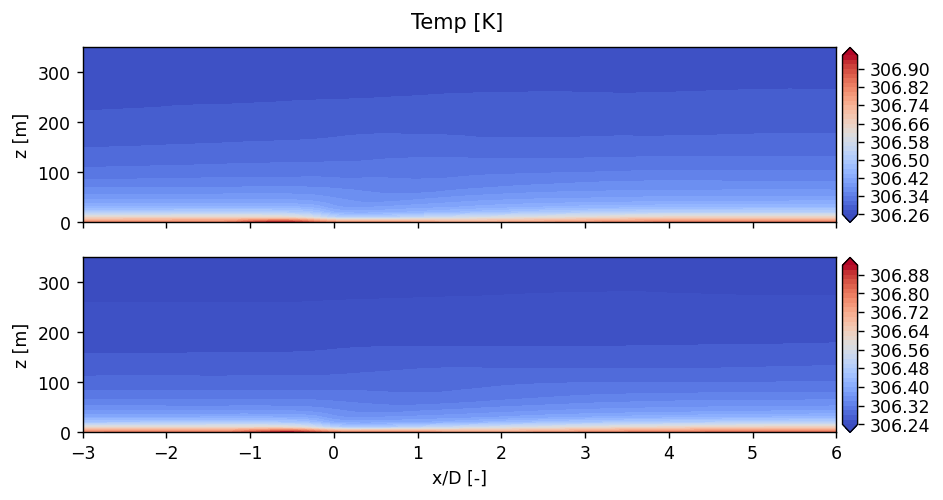

In [10]:
plotvar= 'temperature_avg'
levels = 41 #np.linspace(0, 4, 41) 
fig, axs = plt.subplots(2, 1, figsize=(8, 4), dpi=125, sharex=True)
c0=axs[0].contourf(xp/rotorD, zp, avgup_wturb[plotvar][0,:,:],   levels=levels, cmap='coolwarm', extend='both')
c1=axs[1].contourf(xp/rotorD, zp, avgdown_wturb[plotvar][0,:,:], levels=levels, cmap='coolwarm', extend='both')

# Add colorbar
cax = make_axes_locatable(axs[0]).append_axes("right", size="2%", pad=0.05)
cbar=fig.colorbar(c0, ax=axs[0], cax=cax)
cax = make_axes_locatable(axs[1]).append_axes("right", size="2%", pad=0.05)
cbar=fig.colorbar(c1, ax=axs[1], cax=cax)

for ax in axs:
    ax.set_ylabel('z [m]')
    ax.set_xlim([-3, 6])
    ax.set_ylim([0, 350])
axs[1].set_xlabel('x/D [-]')
fig.suptitle('Temp [K]', y=0.95)

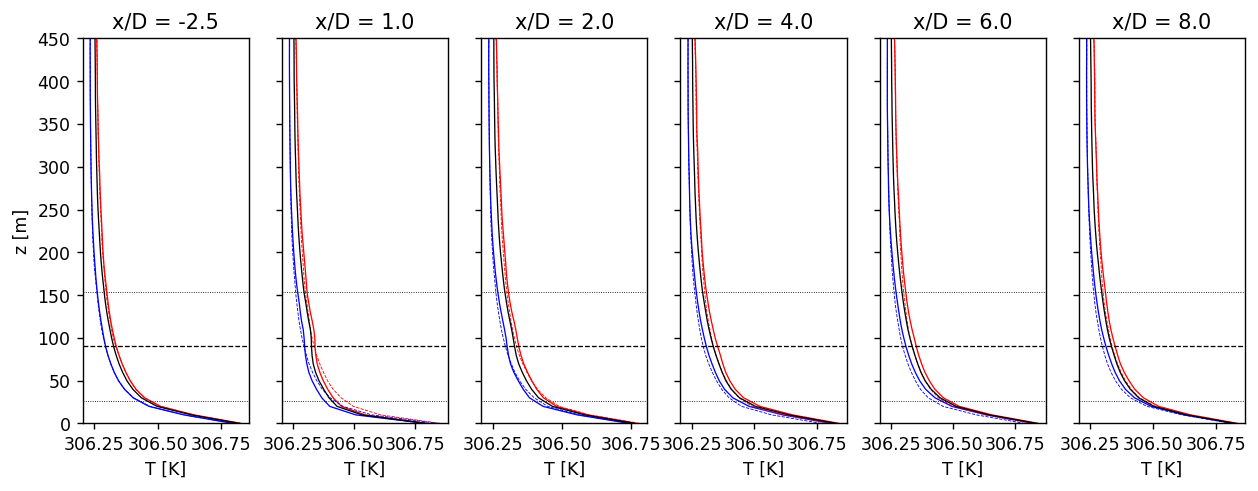

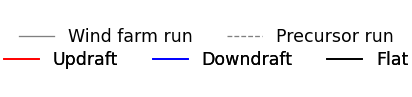

In [11]:
# TKE plots
yvec=zp[:,0]
xvec=xp[0,:]
ivec = [70, 115, 127, 153, 178, 204]

fig, axs = plt.subplots(1, len(ivec), figsize=(12, 4), dpi=125, sharey=True)
plotvar = 'temperature_avg'
for ix, ax in enumerate(axs):
    i = ivec[ix]
    #ax.plot(avgup_wturb[plotvar][0,:,i]-avgup_noturb[plotvar][0,:,i], yvec, 'r', lw=0.75, label='Updraft')
    #ax.plot(avgdown_wturb[plotvar][0,:,i]-avgdown_noturb[plotvar][0,:,i], yvec, 'b', lw=0.75, label='Updraft')
    ax.plot(avgup_wturb[plotvar][0,:,i], yvec, 'r', lw=0.75, label='Updraft')
    ax.plot(avgdown_wturb[plotvar][0,:,i], yvec, 'b', lw=0.75, label='Downdraft')
    ax.plot(avgup_noturb[plotvar][0,:,i], yvec, 'r--', lw=0.5)
    ax.plot(avgdown_noturb[plotvar][0,:,i], yvec, 'b--', lw=0.5)

    ax.plot(avgflat_wturb[plotvar][0,:,i], yvec,  'k', lw=0.75, label='Flat')

    ax.set_title('x/D = %0.1f'%(xvec[i]/rotorD))

    ax.set_xlabel('T [K]')
    ax.axhline(zhh, ls='--', color='k', lw=0.75)
    ax.axhline(zhh+0.5*rotorD, ls=':', color='k', lw=0.5)
    ax.axhline(zhh-0.5*rotorD, ls=':', color='k', lw=0.5)
    #ax.set_xlim([0, 4])
    ax.set_ylim([0, 450])

axs[0].set_ylabel('z [m]')

if savefigs:
    plt.savefig(figdir+'/SW_plane_Temp.png')
    plt.savefig(figdir+'/SW_plane_Temp.pdf')

makelegend()

if savefigs:
    plt.savefig(figdir+'/SW_plane_Temp_legend.png')
    plt.savefig(figdir+'/SW_plane_Temp_legend.pdf')

In [12]:
def saveprofile(datadir, savefname, yvec, dat, plotvar, verbose=True):
    savedat   = np.vstack((yvec, dat))
    np.savetxt(datadir+'/'+savefname, savedat.transpose(), header="Y "+plotvar)
    if verbose: print(datadir+'/'+savefname)
    return
    
# Save the data
ivec = [70, 115, 127, 153, 178, 204]
yvec = zp[:,0]
datadir = 'XZprofiles/'
fname = '{prefix}_{plotvar}_XZ_{xD:0.1f}.dat'
for ix in range(len(ivec)):
    i = ivec[ix]
    plotvar = 'temperature_avg'
    
    savefname = fname.format(prefix="updraft_wturb", plotvar=plotvar, xD=(xvec[i]/rotorD))
    saveprofile(datadir, savefname,yvec, avgup_wturb[plotvar][0,:,i], plotvar)

    savefname = fname.format(prefix="downdraft_wturb", plotvar=plotvar, xD=(xvec[i]/rotorD))
    saveprofile(datadir, savefname,yvec, avgdown_wturb[plotvar][0,:,i], plotvar)

    savefname = fname.format(prefix="updraft_noturb", plotvar=plotvar, xD=(xvec[i]/rotorD))
    saveprofile(datadir, savefname,yvec, avgup_noturb[plotvar][0,:,i], plotvar)

    savefname = fname.format(prefix="downdraft_noturb", plotvar=plotvar, xD=(xvec[i]/rotorD))
    saveprofile(datadir, savefname,yvec, avgdown_noturb[plotvar][0,:,i], plotvar)

    savefname = fname.format(prefix="flat_wturb", plotvar=plotvar, xD=(xvec[i]/rotorD))
    saveprofile(datadir, savefname,yvec, avgflat_wturb[plotvar][0,:,i], plotvar)

XZprofiles//updraft_wturb_temperature_avg_XZ_-2.5.dat
XZprofiles//downdraft_wturb_temperature_avg_XZ_-2.5.dat
XZprofiles//updraft_noturb_temperature_avg_XZ_-2.5.dat
XZprofiles//downdraft_noturb_temperature_avg_XZ_-2.5.dat
XZprofiles//flat_wturb_temperature_avg_XZ_-2.5.dat
XZprofiles//updraft_wturb_temperature_avg_XZ_1.0.dat
XZprofiles//downdraft_wturb_temperature_avg_XZ_1.0.dat
XZprofiles//updraft_noturb_temperature_avg_XZ_1.0.dat
XZprofiles//downdraft_noturb_temperature_avg_XZ_1.0.dat
XZprofiles//flat_wturb_temperature_avg_XZ_1.0.dat
XZprofiles//updraft_wturb_temperature_avg_XZ_2.0.dat
XZprofiles//downdraft_wturb_temperature_avg_XZ_2.0.dat
XZprofiles//updraft_noturb_temperature_avg_XZ_2.0.dat
XZprofiles//downdraft_noturb_temperature_avg_XZ_2.0.dat
XZprofiles//flat_wturb_temperature_avg_XZ_2.0.dat
XZprofiles//updraft_wturb_temperature_avg_XZ_4.0.dat
XZprofiles//downdraft_wturb_temperature_avg_XZ_4.0.dat
XZprofiles//updraft_noturb_temperature_avg_XZ_4.0.dat
XZprofiles//downdraft_noturb_

Text(0, 0.5, 'z [m]')

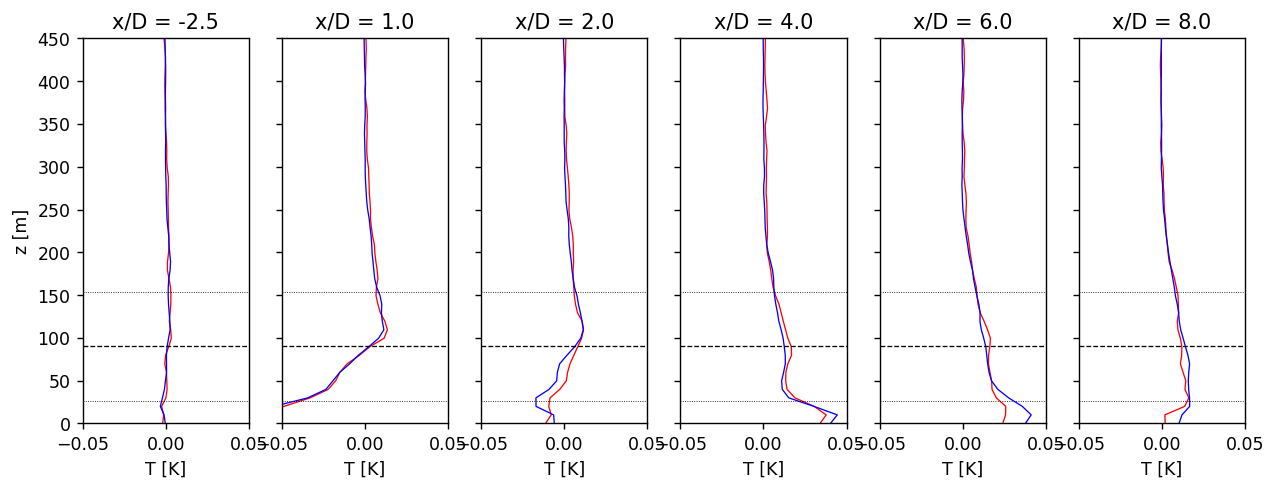

In [13]:
# TKE plots
yvec=zp[:,0]
xvec=xp[0,:]
ivec = [70, 115, 127, 153, 178, 204]

fig, axs = plt.subplots(1, len(ivec), figsize=(12, 4), dpi=125, sharey=True)
plotvar = 'temperature_avg'
for ix, ax in enumerate(axs):
    i = ivec[ix]
    ax.plot(avgup_wturb[plotvar][0,:,i]-avgup_noturb[plotvar][0,:,i], yvec, 'r', lw=0.75, label='Updraft')
    ax.plot(avgdown_wturb[plotvar][0,:,i]-avgdown_noturb[plotvar][0,:,i], yvec, 'b', lw=0.75, label='Updraft')
    #ax.plot(avgup_wturb[plotvar][0,:,i], yvec, 'r', lw=0.75, label='Updraft')
    #ax.plot(avgdown_wturb[plotvar][0,:,i], yvec, 'b', lw=0.75, label='Downdraft')
    #ax.plot(avgup_noturb[plotvar][0,:,i], yvec, 'r--', lw=0.5)
    #ax.plot(avgdown_noturb[plotvar][0,:,i], yvec, 'b--', lw=0.5)

    #ax.plot(avgflat_wturb[plotvar][0,:,i], yvec,  'k', lw=0.75, label='Flat')

    ax.set_title('x/D = %0.1f'%(xvec[i]/rotorD))

    ax.set_xlabel('T [K]')
    ax.axhline(zhh, ls='--', color='k', lw=0.75)
    ax.axhline(zhh+0.5*rotorD, ls=':', color='k', lw=0.5)
    ax.axhline(zhh-0.5*rotorD, ls=':', color='k', lw=0.5)
    ax.set_xlim([-0.05, 0.05])
    ax.set_ylim([0, 450])

axs[0].set_ylabel('z [m]')